In [2]:
import pandas as pd, numpy as np, os, glob, seaborn as sns

In [33]:
def del_empty(lst):
    if isinstance(lst, list):
        return [del_empty(sub) for sub in lst if sub != []]
    return lst

def flatten(t):
    return [item for sublist in t for item in sublist]

In [41]:
base_dirs = ['./results/charts/slip-videos/', './results/charts/no-slip-videos']
conditions = ['Slip', 'No-Slip']
super_list = []
for base_dir, condition in zip(base_dirs, conditions):
    confidence_dirs = os.listdir(base_dir)
    for dir in sorted(confidence_dirs):
        lists = []
        active_dir = os.path.join(base_dir, dir)
        files_to_parse = glob.glob(active_dir + '/*.csv')
        for file in sorted(files_to_parse):
            parsed_confidence = os.path.dirname(file).split('/', 4)[4].split('-')[0:2]
            addition = {'Condition': condition, 'Confidence': '.'.join(parsed_confidence)}
            df = pd.read_csv(file)
            df = df.drop(df.columns[0], axis = 1)
            try:
                output_dictionary = df.groupby(['File']).agg(num_falls = ('Track ID', 'count')).reset_index().to_dict('records')
            except KeyError:
                pass
            if len(output_dictionary) == 0:
                pass
            else:
                output_dictionary[0].update(addition)
            lists.append(output_dictionary)
        cleaned = del_empty(lists)
        super_list.append(flatten(cleaned))
df = pd.DataFrame(flatten(super_list))
    

In [90]:
compiled_df = df.groupby(['Condition', 'Confidence']).agg(num_videos = ('File', 'count')).reset_index()
output_df = []
for identity, data in compiled_df.groupby('Condition'):
    if identity == 'No-Slip':
        num = 270
        column_name = 'FPR'
        name = './results/no-slip-data.csv'
    else:
        num = 41
        column_name = 'TPR'
        name = './results/slip-data.csv'
    data[column_name] = data['num_videos'].apply(lambda x: x/num)
    finished_df = pd.DataFrame(data)
    finished_df.to_csv(name)
    output_df.append(finished_df.drop(['Condition', 'num_videos'], axis = 1))

In [84]:
plotting_df = output_df[0].merge(output_df[1], how = 'inner', on = 'Confidence')

In [96]:
plotting_df.to_csv('./results/tpr-fpr-data.csv')

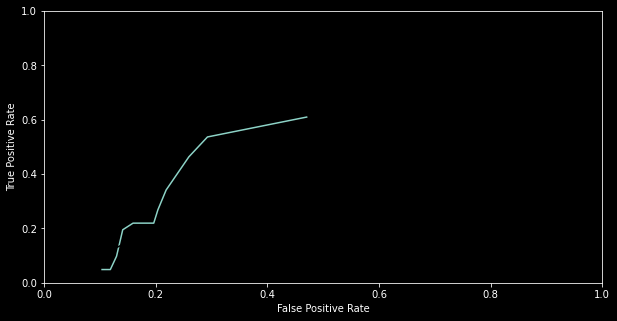

In [95]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(1, figsize = (10,5))
ax.plot(plotting_df['FPR'], plotting_df['TPR'])
ax.plot([0, 1], [0, 1], 'k--')
ax.set(xlim = [0.0, 1.0], ylim = [0.0, 1.0], xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')
f.savefig('./results/roc-curve-yolact-thresholds.png')
